# Figure S1

In [1]:
# Supplementary figure 1: Response to elevated glucose concentrations in steps.
using DifferentialEquations
using LabelledArrays
using Parameters
using MitochondrialDynamics
import MitochondrialDynamics.Utils: second, μM, mV, mM, Hz

# Plotting
import PyPlot as plt
rcParams = plt.PyDict(plt.matplotlib."rcParams")
rcParams["font.size"] = 14
rcParams["font.sans-serif"] = "Arial"
rcParams["font.family"] = "sans-serif"

"sans-serif"

In [2]:
u0 = LVector(g3p = 2.8μM,
             pyr = 8.5μM,
             nadh_c = 1μM,
             nadh_m = 60μM,
             atp_c = 4000μM,
             adp_c = 500μM,
             ca_m = 0.250μM,
             dpsi = 100mV,
             x2=0.25, x3=0.05)
tend = 3000.0
param = MitoDynNode()
prob = ODEProblem(model!, u0, tend, param)

sol = solve(prob)
uInf = sol.u[end]

10-element LArray{Float64, 1, Vector{Float64}, (:g3p, :pyr, :nadh_c, :nadh_m, :atp_c, :adp_c, :ca_m, :dpsi, :x2, :x3)}:
    :g3p => 0.002895941898710723
    :pyr => 0.008754847026251157
 :nadh_c => 0.000982389435045987
 :nadh_m => 0.05727316361054423
  :atp_c => 3.594666227169351
  :adp_c => 0.7569404063087253
   :ca_m => 0.00020167474243294528
   :dpsi => 0.0921900330251806
     :x2 => 0.2432964532981434
     :x3 => 0.05827643690902566

In [3]:
@show getx1(uInf) avgdeg(uInf)

getx1(uInf) = 0.3385777826766362
avgdeg(uInf) = 1.5621322328618585


1.5621322328618585

In [4]:
"Create a function to change glucose level for callbacks"
function make_glc_event(glc, newdt=0.01)
    return i -> begin
        i.p = setglc(i.p, glc)
        set_proposed_dt!(i, newdt)
    end
end

make_glc_event

In [5]:
cb1 = PresetTimeCallback([1000.0second], make_glc_event(10mM))
cb2 = PresetTimeCallback([2000.0second], make_glc_event(15mM))
cbs = CallbackSet(cb1, cb2)

sol1s = solve(ODEProblem(model!, uInf, tend, param), callback=cbs);

In [6]:
function plot_fig1s(sol1s, tend; figsize=(15,15))
    ts = LinRange(0.0, tend, 201)
    g3p = sol1s.(ts, idxs=1)
    pyr = sol1s.(ts, idxs=2)
    nadh_c = sol1s.(ts, idxs=3)
    nadh_m = sol1s.(ts, idxs=4)
    atp_c = sol1s.(ts, idxs=5)
    adp_c = sol1s.(ts, idxs=6)
    amp_c = ampcyto.(adp_c, atp_c, Ref(param))
    ca_m = sol1s.(ts, idxs=7)
    ca_c = cacyto.(adp_c, atp_c, Ref(param), ts)
    ΔΨ = sol1s.(ts, idxs=8)
    x2 = sol1s.(ts, idxs=9)
    x3 = sol1s.(ts, idxs=10)
    x1 = getx1.(x2, x3)
    degree = avgdeg.(x2, x3, x1)

    # convert unit to μM
    for arr in (g3p, pyr, nadh_c, nadh_m, atp_c, adp_c, amp_c, ca_m, ca_c, ΔΨ)
        arr .*= 1000
    end

    fig, ax = plt.subplots(3, 3, figsize=figsize)
    ax[1, 1].plot(ts, g3p, label=nothing)
    ax[1, 1].set(title="(A) G3P (μM)", ylim=(0.0, 10.0))

    ax[1, 2].plot(ts, pyr)
    ax[1, 2].set(title="(B) Pyruvate (μM)", ylim=(0.0, 80.0))

    ax[1, 3].plot(ts, ca_c, label="cyto")
    ax[1, 3].plot(ts, ca_m, label="mito")
    ax[1, 3].set(ylim=(0.0, 1.5), title="(C) Calcium (μM)")
    ax[1, 3].legend(loc="upper left")

    ax[2, 1].plot(ts, nadh_c, label="cyto")
    ax[2, 1].plot(ts, nadh_m, label="mito")
    ax[2, 1].set(title="(D) NADH (μM)")
    ax[2, 1].legend()

    ax[2, 2].plot(ts, atp_c, label="ATP")
    ax[2, 2].plot(ts, adp_c, label="ADP")
    ax[2, 2].plot(ts, amp_c, label="AMP")
    ax[2, 2].set(title="(E) Adenylates (μM)")
    ax[2, 2].legend()

    ax[2, 3].plot(ts, atp_c ./ adp_c)
    ax[2, 3].set(title="(F) ATP/ADP ratio", ylim=(0.0, 45.0) )

    ax[3, 1].plot(ts, ΔΨ)
    ax[3, 1].set(title="(G) ΔΨ (mV)", ylim=(80, 150), xlabel="Time (seconds)")

    ax[3, 2].plot(ts, x1, label="X1")
    ax[3, 2].plot(ts, x2, label="X2")
    ax[3, 2].plot(ts, x3, label="X3")
    ax[3, 2].set(title="(H) Mitochondrial nodes", xlabel="Time (seconds)", ylim=(0.0, 0.6))
    ax[3, 2].legend()

    ax[3, 3].plot(ts, degree)
    ax[3, 3].set(title="(I) Average Node Degree", xlabel="Time (seconds)")

    plt.tight_layout()
    return fig
end

plot_fig1s (generic function with 1 method)

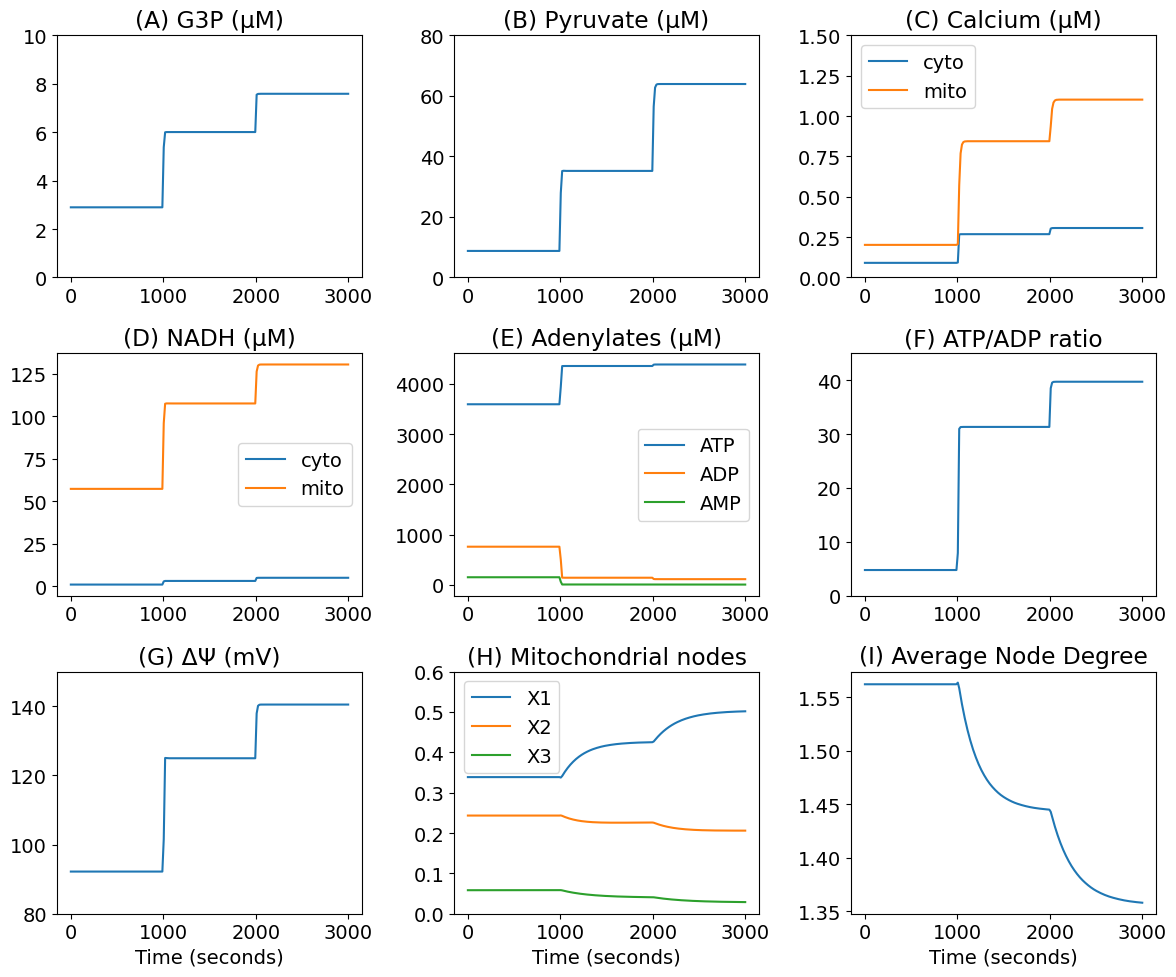

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /builds/NTUMito/wen-wei-tseng/MitochondrialDynamics/.julia/packages/PyCall/L0fLP/src/numpy.jl:67
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


In [7]:
fig1s = plot_fig1s(sol1s, tend, figsize=(12,10));

In [8]:
# Uncomment to generate pdf
# fig1s.savefig("S1_Fig1.pdf")